# Advanced ML: Домашнее задание 1

In [738]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer

from scipy.stats import multivariate_normal

# 1.
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная
с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве
целевой переменной возьмём число случаев заболевания (столбцы total_cases и
new_cases); для упрощения обработки можно заменить в столбце new_cases все
нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в
виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно
использовать в качестве тестового набора (и он даже будет увеличиваться по мере
выполнения задания).

In [739]:
DATE_FORMAT = "%Y-%m-%d"
START_DATE = "2020-03-03"
TRAIN_DAYS = 50

In [740]:
#! wget https://covid.ourworldindata.org/data/owid-covid-data.csv

In [741]:
data = pd.read_csv("owid-covid-data.csv")
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [742]:
def get_data_to_date(date):
    finish_date = (datetime.datetime.strptime(START_DATE, DATE_FORMAT) + datetime.timedelta(days)).strftime(DATE_FORMAT)
    return get_data_to_date(finish_date)
    
def get_data_to_date(finish_date):
    data = pd.read_csv("owid-covid-data.csv")
    df = data[
        (data["location"] == "Russia") & 
        (data["date"] >= START_DATE) & 
        (data["date"] <= finish_date)
    ]
    
    day_col = (pd.to_datetime(df['date'], format=DATE_FORMAT) - datetime.datetime.strptime(START_DATE, DATE_FORMAT)).apply(lambda x: x.days)
    res_df = df.copy()
    
    res_df["day"] = day_col
    return res_df[["day", "total_cases", "new_cases"]]

In [743]:
df = get_data(100)
df.head()

,day,total_cases,new_cases
123273,0,3.0,0.0
123274,1,3.0,0.0
123275,2,4.0,1.0
123276,3,13.0,9.0
123277,4,13.0,0.0


# 2.
Постройте графики целевых переменных. Вы увидите, что число заболевших
растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к
снаряду давайте это и используем.

Text(0.5, 1.0, 'new cases')

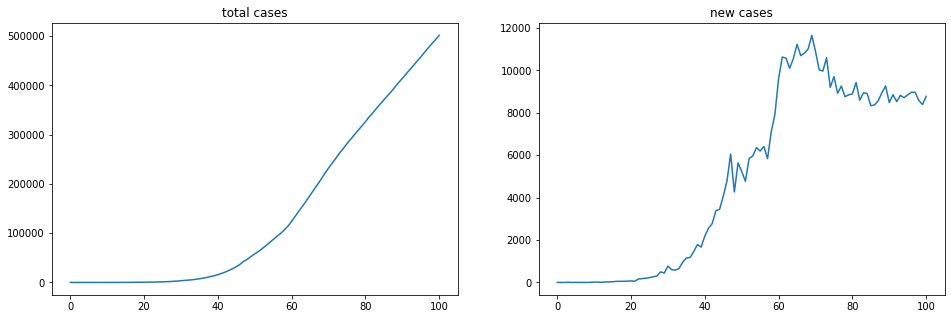

In [744]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].plot(df["day"], df["total_cases"])
axs[0].set_title("total cases")

axs[1].plot(df["day"], df["new_cases"])
axs[1].set_title("new cases")

## 2.a
Используя линейную регрессию, обучите модель с экспоненциальным
ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер
текущего дня.

In [745]:
X = df["day"]
y_total = df["total_cases"]
y_new = df["new_cases"]

X_train = X[:TRAIN_DAYS]
X_test = X[TRAIN_DAYS:]

y_train_total = y_total[:TRAIN_DAYS]
y_test_total = y_total[TRAIN_DAYS:]

y_train_new = y_new[:TRAIN_DAYS]
y_test_new = y_new[TRAIN_DAYS:]

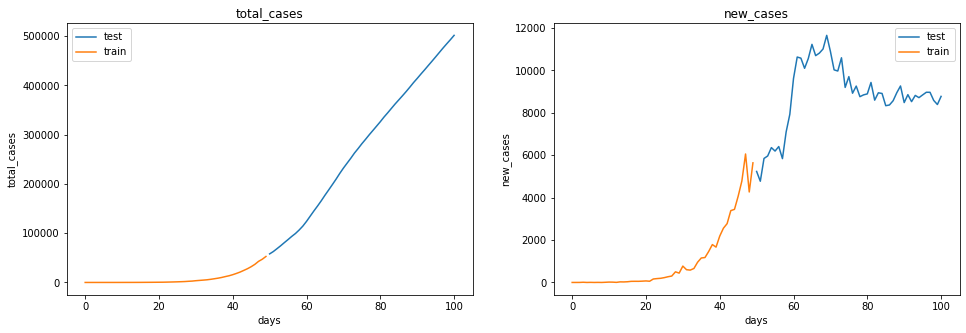

In [746]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(X_test, y_test_total, label="test")
ax[0].plot(X_train, y_train_total, label="train")

ax[0].set_title("total_cases")
ax[0].set_xlabel("days")
ax[0].set_ylabel("total_cases")
ax[0].legend()


ax[1].plot(X_test, y_test_new, label="test")
ax[1].plot(X_train, y_train_new, label="train")

ax[1].set_xlabel("days")
ax[1].set_ylabel("new_cases")
ax[1].set_title("new_cases")
ax[1].legend()

plt.show()

In [747]:
def train_lr(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(add_dim(X_train), np.log(y_train))

    train_error = mse(np.log(y_train), model.predict(add_dim(X_train)))
    test_error  = mse(np.log(y_test ), model.predict(add_dim(X_test)))
    
    print(f"Test  error: {test_error}")
    print(f"Train error: {train_error}")
    
    return model

def train_reg_lr(model, X_train, y_train, X_test, y_test):
    
    grid_params = {"alpha": np.arange(0.001, 10000, 20000)}
    grid_scorer = make_scorer(mse, greater_is_better=False)
    grid = GridSearchCV(estimator=model, param_grid=grid_params, verbose=0, scoring=grid_scorer)
    grid_results = grid.fit(add_dim(X_train), np.log(y_train))

    best_model = grid_results.best_estimator_
    
    train_error = mse(np.log(y_train), best_model.predict(add_dim(X_train)))
    test_error  = mse(np.log(y_test ), best_model.predict(add_dim(X_test)))
    
    print(f"Test error : {test_error}")
    print(f"Train error: {train_error}")
    
    return best_model

In [748]:
print("Base linear model:")
lr = train_lr(X_train, y_train_total, X_test, y_test_total)
print("="* 20, "\nLinear model with L1 regularization:")
lasso_lr = train_reg_lr(Lasso(), X_train, y_train_total, X_test, y_test_total)
print("="* 20, "\nLinear model with L2 regularization:")
ridge_lr = train_reg_lr(Ridge(), X_train, y_train_total, X_test, y_test_total)

Base linear model:
Test  error: 24.158231732017473
Train error: 0.12183046154391235
Linear model with L1 regularization:
Test error : 24.15580294729337
Train error: 0.12183046634583308
Linear model with L2 regularization:
Test error : 24.158222099647617
Train error: 0.12183046154398786


In [749]:
0.12183046154398786 < 0.12183046634583308

True

Конечно, регуляризация не сильно улучшит ситуацию, когда посылка постоянно экспоненциального роста неверна. 

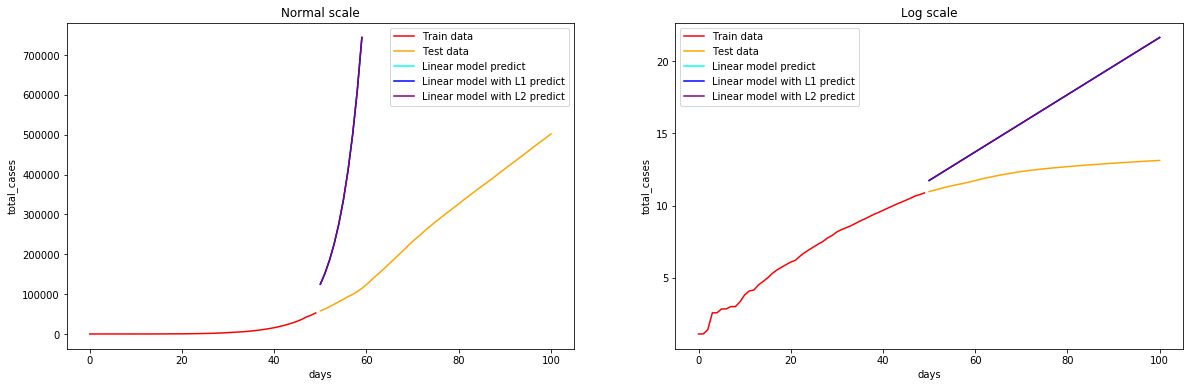

In [750]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# normal scale
ax[0].plot(X_train, y_train_total, color='red',    label="Train data")
ax[0].plot(X_test, y_test_total, color='orange', label="Test data")

# для масштаба взял первые 10 отсчетов
ax[0].plot(X_test[:10], np.exp(lr.predict(add_dim(X_test[:10]))), color='cyan', label="Linear model predict")
ax[0].plot(X_test[:10], np.exp(lasso_lr.predict(add_dim(X_test[:10]))), color='blue', label="Linear model with L1 predict")
ax[0].plot(X_test[:10], np.exp(ridge_lr.predict(add_dim(X_test[:10]))), color='purple', label="Linear model with L2 predict")

ax[0].set_xlabel('days')
ax[0].set_ylabel('total_cases')
ax[0].set_title('Normal scale')
ax[0].legend()

# log scale
ax[1].plot(X_train, np.log(y_train_total), color='red',    label="Train data")
ax[1].plot(X_test,  np.log(y_test_total), color='orange', label="Test data")

# для масштаба взял первые 10 отсчетов - иначе тестовые данные превращались в линию
ax[1].plot(X_test, lr.predict(add_dim(X_test)), color='cyan', label="Linear model predict")
ax[1].plot(X_test, lasso_lr.predict(add_dim(X_test)), color='blue', label="Linear model with L1 predict")
ax[1].plot(X_test, ridge_lr.predict(add_dim(X_test)), color='purple', label="Linear model with L2 predict")

ax[1].set_xlabel('days')
ax[1].set_ylabel('total_cases')
ax[1].set_title('Log scale')
ax[1].legend()

plt.show()

## 2.b
Обучите эти параметры на датасете случаев коронавируса в России.
Найдите апостериорное распределение параметров этой модели для
достаточно широкого априорного распределения. Требующееся для этого
значение дисперсии шума в данных оцените, исходя из вашей же
максимальной апостериорной модели.

Предположим, что шум имеет нормальное распределение. 

In [751]:
def get_mu_sigma(X, y):
    init_mu = np.zeros(2)
    init_sigma = 20 * np.eye(2)
    
    y_pred = lr.predict(add_dim(X))
    noise_var = (y - y_pred).var()
    alpha = 1 / noise_var
        
    sigma = np.linalg.inv(np.linalg.inv(init_sigma) + add_dim(X).T @ X / noise_var)
    mu = sigma @ (np.linalg.inv(init_sigma) @ init_mu + add_dim(X).T @ y / noise_var)
    
    return mu, sigma

In [752]:
mu, sigma = get_mu_sigma(X_train, y_train_total)
print("mu =", mu)
print("sigma =", sigma)

mu = [0.03634034 1.91809292]
sigma = [[ 1.99973347e+01 -8.79535666e-02]
 [-2.66525959e-03  1.99120464e+01]]


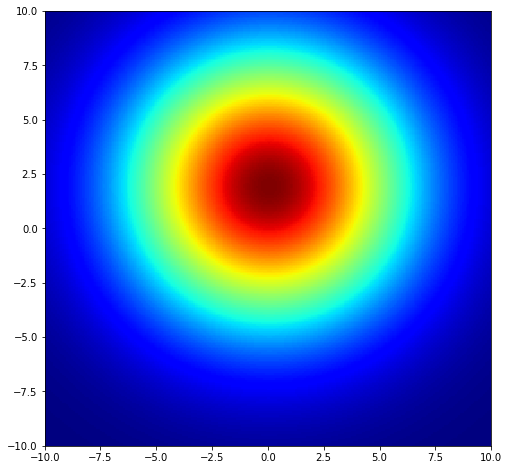

In [753]:
N = 250
limits = (-10, 10)

X = np.linspace(*limits, N)
Y = np.linspace(*limits, N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)

plt.figure(figsize=(8, 8))
plt.xlim(limits)
plt.ylim(limits)

plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
plt.show();

## 2.с 
Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя
из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к
1 июня? к 1 сентября? Постройте предсказательные распределения (можно
эмпирически, исходя из данных сэмплирования).

In [754]:
df_may = get_data_to_date("2020-05-01")
df_june = get_data_to_date("2020-06-01")
df_sept = get_data_to_date("2020-09-01")

X_may = df_may["day"]
X_june = df_june["day"]
X_sept = df_sept["day"]

y_may_total = np.exp(lr.predict(add_dim(X_may)))
y_june_total = np.exp(lr.predict(add_dim(X_june)))
y_sept_total = np.exp(lr.predict(add_dim(X_sept)))

print(f"К 1 мая: {int(y_may_total[-1])} случаев")
print(f"К 1 июня: {int(y_june_total[-1])} случаев")
print(f"К 1 сентября: {int(y_sept_total[-1])} случаев")

К 1 мая: 744077 случаев
К 1 июня: 347723874 случаев
К 1 сентября: 29104907396230312 случаев


In [755]:
def get_samples(X, n_samples, mu, sigma):
    w_arr = np.random.multivariate_normal(mu, sigma, n_samples)
    res = np.zeros((len(w_arr), len(X)))
    
    for i, w in enumerate(w_arr):
        res[i] = X @ w
    return res

In [756]:
X.shape

(250, 250)

C:\Users\v.alehin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


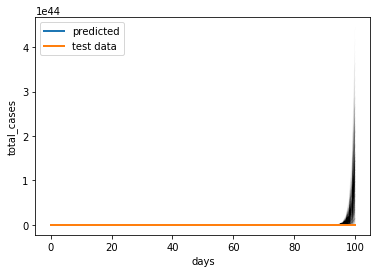

In [761]:
n_samples = 1000

for w in  np.random.multivariate_normal(mu, sigma, n_samples):
    plt.plot(X_sample, np.absolute(np.exp(add_dim(X_sample)) @ w), 'k-', lw=.01)
    
plt.plot(X_sample, np.exp(lr.predict(add_dim(X_sample))), lw=2, label='predicted')
plt.plot(X_sample, y_total, lw=2, label='test data')

plt.xlabel('days')
plt.ylabel('total_cases')
plt.legend()
plt.show()

# 3
Предсказания экспоненциальной модели наверняка получились грустными. Но это,
конечно, чересчур пессимистично — экспоненциальный рост в природе никак не
может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в
реальности имеет сигмоидальный вид: после начальной фазы экспоненциального
роста неизбежно происходит насыщение. В качестве конкретной формы такой
сигмоиды давайте возьмём форму функции распределения для гауссиана :

$$\Phi(x)=\frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x}e^{\frac{-t^2}{2}}dt$$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа
перед интегралом может быть произвольной (и её можно внести в экспоненту), а в
экспоненте под интегралом может быть произвольная квадратичная функция от t.


## 3.a
Предложите способ обучать параметры такой сигмоидальной функции при
помощи линейной регрессии.

Если продифференцировать приведенную функцию сигмоиды, то мы получим экспоненту с полиномом в степени. Смысл операции дифференцирования сводится к тому, что теперь мы будем предсказывать не число заболевших, а их прирост в день. Взятие логарифма от полученного приведет нас к модели, которую вполне можно представить через линейную модель.
Таким образом:
- добавляем еще один признак в вектор Х - квадрат от дня (вытекает из $t^2$ в показателе степени экспоненты);
- предсказываем прирост, а не число заболевших.

In [766]:
def add_feature(X):
    return np.stack([np.ones(X.shape[0]), X, X **2], axis=-1)

df = get_data(75)
X = add_feature(df["day"])
X_train = X[:TRAIN_DAYS]
X_test = X[TRAIN_DAYS:]

y_new = df["new_cases"]
y_train_new = y_new[:TRAIN_DAYS]
y_test_new = y_new[TRAIN_DAYS:]

y_total = df["total_cases"]
y_train_total = y_total[:TRAIN_DAYS]
y_test_total = y_total[TRAIN_DAYS:]

y_train_new_ln = np.log(y_train_new).replace([np.inf, -np.inf], 0)
y_test_new_ln = np.log(y_test_new).replace([np.inf, -np.inf], 0)

C:\Users\v.alehin\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [767]:
def train_lr(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)

    train_error = mse(y_train, model.predict(X_train))
    test_error  = mse(y_test, model.predict(X_test))
    
    print(f"Test  error: {test_error}")
    print(f"Train error: {train_error}")
    
    return model

def train_reg_lr(model, X_train, y_train, X_test, y_test):
    
    grid_params = {"alpha": np.arange(0.001, 10000, 20000)}
    grid_scorer = make_scorer(mse, greater_is_better=False)
    grid = GridSearchCV(estimator=model, param_grid=grid_params, verbose=0, scoring=grid_scorer)
    grid_results = grid.fit(X_train, y_train)

    best_model = grid_results.best_estimator_
    
    train_error = mse(y_train, best_model.predict(X_train))
    test_error  = mse(y_test, best_model.predict(X_test))
    
    print(f"Test error : {test_error}")
    print(f"Train error: {train_error}")
    
    return best_model

In [768]:
print("Base linear model:")
lr = train_lr(X_train, y_train_new_ln, X_test, y_test_new_ln)
print("="* 20, "\nLinear model with L1 regularization:")
lasso_lr = train_reg_lr(Lasso(), X_train, y_train_new_ln, X_test, y_test_new_ln)
print("="* 20, "\nLinear model with L2 regularization:")
ridge_lr = train_reg_lr(Ridge(), X_train, y_train_new_ln, X_test, y_test_new_ln)

Base linear model:
Test  error: 0.3065984777544678
Train error: 0.23928684127005564
Linear model with L1 regularization:
Test error : 0.30874728874630425
Train error: 0.239286931320377
Linear model with L2 regularization:
Test error : 0.3066091701451621
Train error: 0.2392868412723076


C:\Users\v.alehin\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


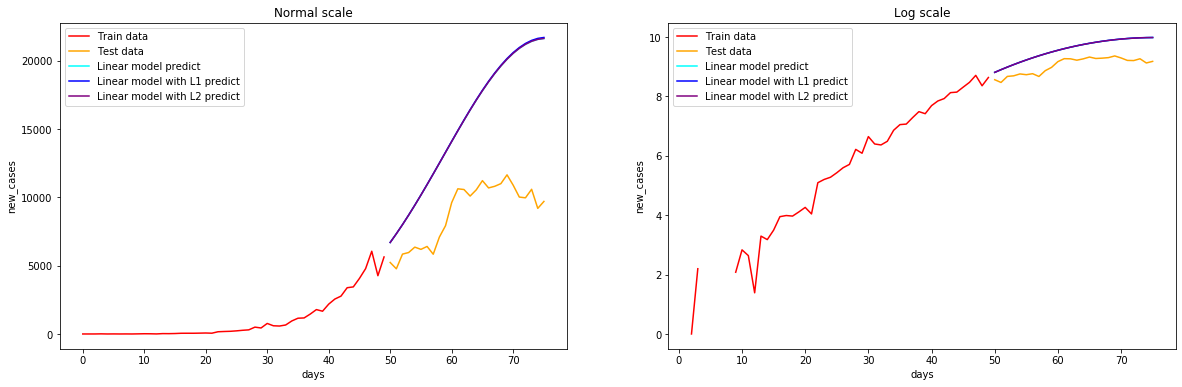

In [769]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# normal scale
ax[0].plot(X_train[:, 1], y_train_new, color='red',    label="Train data")
ax[0].plot(X_test[:, 1], y_test_new, color='orange', label="Test data")

ax[0].plot(X_test[:, 1], np.exp(lr.predict(X_test)), color='cyan', label="Linear model predict")
ax[0].plot(X_test[:, 1], np.exp(lasso_lr.predict(X_test)), color='blue', label="Linear model with L1 predict")
ax[0].plot(X_test[:, 1], np.exp(ridge_lr.predict(X_test)), color='purple', label="Linear model with L2 predict")

ax[0].set_xlabel('days')
ax[0].set_ylabel('new_cases')
ax[0].set_title('Normal scale')
ax[0].legend()

# log scale
ax[1].plot(X_train[:, 1], np.log(y_train_new), color='red',    label="Train data")
ax[1].plot(X_test[:, 1],  np.log(y_test_new), color='orange', label="Test data")

# для масштаба взял первые 10 отсчетов - иначе тестовые данные превращались в линию
ax[1].plot(X_test[:, 1], lr.predict(X_test), color='cyan', label="Linear model predict")
ax[1].plot(X_test[:, 1], lasso_lr.predict(X_test), color='blue', label="Linear model with L1 predict")
ax[1].plot(X_test[:, 1], ridge_lr.predict(X_test), color='purple', label="Linear model with L2 predict")

ax[1].set_xlabel('days')
ax[1].set_ylabel('new_cases')
ax[1].set_title('Log scale')
ax[1].legend()

plt.show()

Описывает чуть-чуть лучше, да и появилась "полочка" - рост не уходит в бесконечность.

# 3.b
Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [770]:
def get_mu_sigma(model, x, y):
    init_mu = np.array([model.intercept_, model.coef_[1], model.coef_[2]]) # lr.coef_[0] = 0
    init_sigma = 2 * np.eye(3)

    res_sigma = np.linalg.inv((
        np.linalg.inv(init_sigma.astype(float)) + (1 / (sn ** 2)) * np.matmul(np.transpose(x), x) 
    ).astype(float))
    #print(res_sigma.shape)
    #print(mu.shape, sigma.shape)
    #print(x.shape, y.shape)
    #print(np.matmul(x.T, y).shape)

    a = np.matmul(np.linalg.inv(init_sigma), np.transpose(init_mu)) + (1 / (sn ** 2)) * np.matmul(x.T, y)
    res_mu = np.matmul(res_sigma, a)

    return res_mu, res_sigma

In [774]:
mu, sigma = get_mu_sigma(ridge_lr, X_train, y_train_new_ln)
print(f"mu: {mu}")
print(f"sigma: {sigma}")

mu: [-0.39659033  0.27562283 -0.00182979]
sigma: [[ 3.90201341e-02 -3.15245662e-03  5.30704019e-05]
 [-3.15245662e-03  3.49440919e-04 -6.68064624e-06]
 [ 5.30704019e-05 -6.68064624e-06  1.36646185e-07]]


## 3.c
Посэмплируйте много разных сигмоид из апостериорного распределения,
постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев
коронавируса в России? Постройте эмпирическое предсказательное
распределение, нарисуйте графики. Каков ваш прогноз числа случаев
коронавируса в пессимистичном сценарии (90-й процентиль в выборке
числа случаев)? В оптимистичном сценарии (10-й процентиль)?

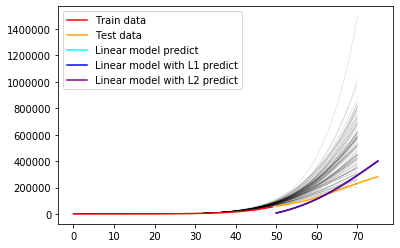

In [782]:
# sample
x_arr = np.linspace(0, 70, 100)
for w in np.random.multivariate_normal(mu, sigma, n):
    plt.plot(x_arr, np.cumsum(np.exp(w[0] + w[1] * x_arr + w[2] * x_arr ** 2)), "k-", lw=0.08)

# source
plt.plot(X_train[:, 1], y_train_total, color="red",    label="Train data")
plt.plot(X_test[:, 1], y_test_total, color="orange", label="Test data")

# predict
plt.plot(X_test[:, 1], np.cumsum(np.exp(lr.predict(X_test))), color='cyan', label="Linear model predict")
plt.plot(X_test[:, 1], np.cumsum(np.exp(lasso_lr.predict(X_test))), color='blue', label="Linear model with L1 predict")
plt.plot(X_test[:, 1], np.cumsum(np.exp(ridge_lr.predict(X_test))), color='purple', label="Linear model with L2 predict")

plt.legend()
plt.show()